# Linear Optimization

Optimizes a linear straight-line path from a point on the viable brain surface region to a point on the subthalamic nucleus (STN) for DBS electrode planning.

Treats the following as obstacles:
- Sulci
- Ventricles
- Corpus Callosum (prevent brain crossing)

**Objective Functions**
- Distance to obstacles
- Minimum path distance  *(not optimized yet)*

## Setup

### Import Libraries

In [1]:
import os
import glob
import random
import numpy as np

import vedo
from vedo import Volume, show, Line, merge, Plotter

### Configuration and Setup

In [2]:
# Define paths and folder names
base_dir = "./FINAL_BRAIN_ATLAS/nii_exports"
brainmask_folder_name = "BRAIN_MASK"
corpus_callosum_folder_name = "CORPUS_CALLLOSUM"
stn_folder_name = "SUBTHALAMIC_NUCLEUS"
sulci_folder_name = "SULCI"
ventricles_folder_name = "VENTRICLES"

obstacle_names = [corpus_callosum_folder_name,
                  sulci_folder_name,
                  ventricles_folder_name]

stn_dir = os.path.join(base_dir, stn_folder_name)

### Load Brain Structures

Load NIfTI files for:
- Brain mask (grey surface)
- Obstacles (corpus callosum, sulci, ventricles in red)
- STN target (green)

In [3]:
# Initialize lists for different structure types
stn_structures = []
obstacle_structures = []
brain_mask_structures = []

for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue

    nii_files = glob.glob(os.path.join(folder_path, "*.nii")) + \
                glob.glob(os.path.join(folder_path, "*.nii.gz"))

    if not nii_files:
        continue

    # Brain mask
    if folder_name == brainmask_folder_name:
        for fpath in nii_files:
            fname = os.path.basename(fpath)
            print(f"  Loading structure: {fname}")
            vol = Volume(fpath)
            surf = vol.isosurface()
            surf.c("grey").alpha(0.01)
            brain_mask_structures.append(surf)
    
    # Obstacles
    elif folder_name in obstacle_names:
        for fpath in nii_files:
            fname = os.path.basename(fpath)
            print(f"  Loading structure: {fname}")
            vol = Volume(fpath)
            surf = vol.isosurface()
            surf.c("red").alpha(0.66)
            obstacle_structures.append(surf)
    # STN
    elif folder_name == stn_folder_name:
        for fpath in nii_files:
            fname = os.path.basename(fpath)
            print(f"  Loading structure: {fname}")
            vol = Volume(fpath)
            surf = vol.isosurface()
            surf.c("green").alpha(1.0)
            stn_structures.append(surf)

  Loading structure: Model_1000_left_insula.nii
  Loading structure: Model_1001_left_superior_temporal_gyrus_(banks_of_left_superior_temporal_sulcus).nii
  Loading structure: Model_1002_caudal_part_of_left_anterior_cingulate_gyrus.nii
  Loading structure: Model_1003_posterior_part_of_left_middle_frontal_gyrus.nii
  Loading structure: Model_1005_left_cuneus.nii
  Loading structure: Model_1006_left_ambiens_gyrus.nii
  Loading structure: Model_1007_left_fusiform_gyrus.nii
  Loading structure: Model_1008_left_inferior_parietal_lobule.nii
  Loading structure: Model_1009_left_inferior_temporal_gyrus.nii
  Loading structure: Model_1010_isthmus_of_left_cingulate_gyrus.nii
  Loading structure: Model_1011_left_lateral_occipital_gyrus.nii
  Loading structure: Model_1012_left_lateral_orbital_gyrus.nii
  Loading structure: Model_1013_left_lingual_gyrus.nii
  Loading structure: Model_1014_left_straight_gyrus.nii
  Loading structure: Model_1015_left_middle_temporal_gyrus.nii
  Loading structure: Mode

### Merge Structures

Combine individual structures into single meshes for:
- Brain mask (for sampling start points)
- Obstacles (for intersection detection)
- STN (for sampling target points)

In [4]:
# Merge brain mask structures to define bounding box
merged_brain_mask = None
if brain_mask_structures:
    print("Merging brain mask structures...")
    merged_brain_mask = merge(brain_mask_structures)
    merged_brain_mask.c("grey").alpha(0.01)

# Merge obstacle structures for distance calculations
merged_obstacles = None
if obstacle_structures:
    print("Merging obstacle structures...")
    merged_obstacles = merge(obstacle_structures)
    merged_obstacles.c("red").alpha(0.75)

# Merge STN structures to sample target point
merged_stn = None
if stn_structures:
    print("Merging STN structures...")
    merged_stn = merge(stn_structures)
    merged_stn.c("green").alpha(1.0)

Merging brain mask structures...
Merging obstacle structures...
Merging STN structures...


## Monte Carlo Optimization

### Path Generation and Optimization

Generate random paths from brain surface to STN and evaluate them:
- **Purple lines**: Failed paths (intersect obstacles)
- **Yellow lines**: Successful but suboptimal paths
- **Green line**: Optimal path (maximum distance from obstacles)

**Optimization Algorithm**

Runs until finding a successful path and after a minimum of `min_attempts`.

Chooses a **random location** from the viable brain surface region and the STN of the corresponding hemisphere. 

For each plot, the distance from obstacles is saved. The "best" path is determined using the highest distance to obstacles.

In [37]:
# Configuration for path generation
max_attempts = 1000
min_attempts = 10
successful_attempts = []  # Store (start_point, end_point, distance) tuples
failed_lines = []

# Line width configuration (for visualization)
BEST_PATH_WIDTH = 8
SUBOPTIMAL_PATH_WIDTH = 5
FAILED_PATH_WIDTH = 5

In [38]:
# Generate and evaluate paths
for attempt in range(max_attempts):
    if attempt + 1 > min_attempts:
        break
    
    # Select random start (brain surface)
    random_point = merged_brain_mask.generate_random_points(1)
    start_point = tuple(random_point.points[0])
    print(f"Selected start point within brain mask: {start_point}")
    
    # Select random end (STN surface)
    random_point = merged_stn.generate_random_points(1)
    end_point = tuple(random_point.points[0])
    print(f"Selected end point within STN: {end_point}")
    
    # Check for intersection if we have obstacles
    if merged_obstacles:
        intersections = merged_obstacles.intersect_with_line(start_point, end_point)
        
        # If no intersections (empty array or None), line is valid
        if intersections is None or len(intersections) == 0:
            # Compute distance to obstacles
            temp_line = Line([start_point, end_point])
            d = temp_line.distance_to(merged_obstacles)
            if isinstance(d, (list, tuple, np.ndarray)):
                dval = float(np.min(d))
            else:
                dval = float(d)
            
            successful_attempts.append((start_point, end_point, dval))
            print(f"Attempt {attempt+1}: SUCCESS - Obstacle Distance: {dval:.3f}")
        else:
            # Store failed attempt as purple line
            failed_line = Line([start_point, end_point]).c("purple").alpha(0.3).lw(FAILED_PATH_WIDTH)
            failed_lines.append(failed_line)
            print(f"Attempt {attempt+1}: FAIL - Line intersects obstacles")
    else:
        # No obstacles, accept any line
        temp_line = Line([start_point, end_point])
        successful_attempts.append((start_point, end_point, 0.0))
        print(f"Attempt {attempt+1}: SUCCESS (no obstacles)")
else:
    print(f"Warning: Only found {len(successful_attempts)} non-intersecting lines after {max_attempts} attempts")

Selected start point within brain mask: (np.float32(127.33953), np.float32(96.07916), np.float32(92.98963))
Selected end point within STN: (np.float32(108.86422), np.float32(130.77443), np.float32(73.4102))
Attempt 1: FAIL - Line intersects obstacles
Selected start point within brain mask: (np.float32(100.78903), np.float32(159.06711), np.float32(44.75))
Selected end point within STN: (np.float32(109.11148), np.float32(132.218), np.float32(73.63852))
Attempt 2: SUCCESS - Distance: 2.885
Selected start point within brain mask: (np.float32(146.12224), np.float32(82.17923), np.float32(80.75))
Selected end point within STN: (np.float32(107.729454), np.float32(129.25), np.float32(70.900185))
Attempt 3: FAIL - Line intersects obstacles
Selected start point within brain mask: (np.float32(162.29222), np.float32(93.25), np.float32(110.5143))
Selected end point within STN: (np.float32(109.21424), np.float32(132.72617), np.float32(73.53576))
Attempt 4: FAIL - Line intersects obstacles
Selected st

### Select Optimal Path

Find the best path among successful attempts by maximizing distance from obstacles.

In [39]:
# Find the best path (maximum distance from obstacles)
best_path = None
suboptimal_lines = []

if successful_attempts:
    # Sort by distance (descending)
    successful_attempts.sort(key=lambda x: x[2], reverse=True)
    
    # Best path
    best_start, best_end, best_dist = successful_attempts[0]
    best_path = Line([best_start, best_end]).c("green").lw(BEST_PATH_WIDTH)
    print(f"\nBest path: distance from obstacles {best_dist:.3f}")
    
    # All other successful paths as yellow
    for start_pt, end_pt, dist in successful_attempts[1:]:
        suboptimal_line = Line([start_pt, end_pt]).c("yellow").alpha(0.3).lw(SUBOPTIMAL_PATH_WIDTH)
        suboptimal_lines.append(suboptimal_line)
        print(f"Suboptimal path: distance from obstacles {dist:.3f}")
else:
    print("No successful paths found!")


Best path: distance from obstacles 5.291
Suboptimal path: distance from obstacles 4.632
Suboptimal path: distance from obstacles 4.437
Suboptimal path: distance from obstacles 2.885
Suboptimal path: distance from obstacles 1.945


## Weighted Sum + Nelder-Mead Optimization

### Configuration

Set weights and optimization parameters:
- `w_obstacle`: Weight for obstacle distance (maximize)
- `w_path_length`: Weight for path length (minimize)
- Weights are normalized automatically

In [26]:
from scipy.optimize import minimize

# Weights for multi-objective optimization (easily configurable)
w_obstacle = 0.9     # Weight for obstacle distance (higher = prefer safer paths)
w_path_length = 0.1   # Weight for path length (higher = prefer shorter paths)

# Normalize weights to sum to 1
total_weight = w_obstacle + w_path_length
w_obstacle_norm = w_obstacle / total_weight
w_path_length_norm = w_path_length / total_weight

print(f"Normalized weights:")
print(f"  Obstacle distance: {w_obstacle_norm:.3f}")
print(f"  Path length: {w_path_length_norm:.3f}")

# Nelder-Mead parameters
initial_point_attempts = 10
nm_max_iterations = 1000
nm_tolerance = 1e-6 # initially 1e-6

Normalized weights:
  Obstacle distance: 0.900
  Path length: 0.100


### Helper Functions

Functions to evaluate path quality and compute the weighted sum objective.

In [6]:
def compute_path_length(start_point, end_point):
    """Compute Euclidean distance between start and end points."""
    return np.linalg.norm(np.array(end_point) - np.array(start_point))

def compute_obstacle_distance(start_point, end_point):
    """Compute minimum distance from path to obstacles."""
    if merged_obstacles is None:
        return 0.0
    
    temp_line = Line([start_point, end_point])
    d = temp_line.distance_to(merged_obstacles)
    
    if isinstance(d, (list, tuple, np.ndarray)):
        return float(np.min(d))
    else:
        return float(d)

def check_intersection(start_point, end_point):
    """Check if path intersects obstacles."""
    if merged_obstacles is None:
        return False
    
    intersections = merged_obstacles.intersect_with_line(start_point, end_point)
    return intersections is not None and len(intersections) > 0

def is_point_on_brain_surface(point):
    """Check if point is close to brain mask surface."""
    if merged_brain_mask is None:
        return True
    
    # Check if point is within reasonable distance of brain surface
    distance = merged_brain_mask.distance_to(point)
    return distance < 5.0  # Tolerance threshold

def is_point_on_stn_surface(point):
    """Check if point is close to STN surface."""
    if merged_stn is None:
        return True
    
    # Check if point is within reasonable distance of STN surface
    distance = merged_stn.distance_to(point)
    return distance < 5.0  # Tolerance threshold

### Weighted Sum Objective Function

Combines both objectives (obstacle distance and path length) into a single scalar value for optimization.

In [29]:
# Global variables for normalization (will be computed from sample paths)
max_obstacle_dist = None
max_path_length = None

def weighted_sum_objective(x):
    """
    Weighted sum objective function for optimization.
    
    Parameters:
    -----------
    x : array-like, shape (6,)
        [start_x, start_y, start_z, end_x, end_y, end_z]
    
    Returns:
    --------
    float : Objective value (to be minimized)
    """
    start_point = tuple(x[:3])
    end_point = tuple(x[3:])
    
    # Check for constraint violations
    # 1. Check if path intersects obstacles
    if check_intersection(start_point, end_point):
        return 1e10  # Large penalty for infeasible paths
    
    # Compute objectives
    obstacle_dist = compute_obstacle_distance(start_point, end_point)
    path_length = compute_path_length(start_point, end_point)
    
    # Normalize objectives
    if max_obstacle_dist is not None and max_obstacle_dist > 0:
        norm_obstacle_dist = obstacle_dist / max_obstacle_dist
    else:
        norm_obstacle_dist = obstacle_dist / 100.0  # Default normalization
    
    if max_path_length is not None and max_path_length > 0:
        norm_path_length = path_length / max_path_length
    else:
        norm_path_length = path_length / 200.0  # Default normalization
    
    # Weighted sum: minimize (-obstacle_dist) and minimize path_length
    # We negate obstacle_dist because we want to maximize it
    objective = -w_obstacle_norm * norm_obstacle_dist + w_path_length_norm * norm_path_length
    
    # objective = -w_obstacle_norm * obstacle_dist + w_path_length_norm * path_length
    
    return objective

### Estimate Normalization Constants

Sample a few random paths to estimate typical ranges for obstacle distance and path length.

In [33]:
estimation_samples = 20

In [34]:
# Sample random paths to estimate normalization constants
print("Estimating normalization constants from random samples...")
sample_obstacle_dists = []
sample_path_lengths = []

for _ in range(estimation_samples):
    print(f"  Sampling path {_+1}/{estimation_samples}...")
    
    # Sample random points
    start = tuple(merged_brain_mask.generate_random_points(1).points[0])
    end = tuple(merged_stn.generate_random_points(1).points[0])
    
    # Only use non-intersecting paths for normalization
    if not check_intersection(start, end):
        obstacle_dist = compute_obstacle_distance(start, end)
        path_length = compute_path_length(start, end)
        
        sample_obstacle_dists.append(obstacle_dist)
        sample_path_lengths.append(path_length)

if sample_obstacle_dists:
    max_obstacle_dist = max(sample_obstacle_dists)
    max_path_length = max(sample_path_lengths)
    print(f"Estimated max obstacle distance: {max_obstacle_dist:.2f}")
    print(f"Estimated max path length: {max_path_length:.2f}")
else:
    print("Warning: No valid paths found for normalization, using defaults")
    max_obstacle_dist = 5
    max_path_length = 100

Estimating normalization constants from random samples...
  Sampling path 1/20...
  Sampling path 2/20...
  Sampling path 3/20...
  Sampling path 4/20...
  Sampling path 5/20...
  Sampling path 6/20...
  Sampling path 7/20...
  Sampling path 8/20...
  Sampling path 9/20...
  Sampling path 10/20...
  Sampling path 11/20...
  Sampling path 12/20...
  Sampling path 13/20...
  Sampling path 14/20...
  Sampling path 15/20...
  Sampling path 16/20...
  Sampling path 17/20...
  Sampling path 18/20...
  Sampling path 19/20...
  Sampling path 20/20...
Estimated max obstacle distance: 6.46
Estimated max path length: 84.37


### Run Nelder-Mead Optimization

Use Nelder-Mead simplex algorithm to optimize the weighted sum objective. Starts from a random feasible point.

In [35]:
# Find a feasible starting point
print("\nFinding feasible initial point...")
x0 = None
for attempt in range(initial_point_attempts):
    start = merged_brain_mask.generate_random_points(1).points[0]
    end = merged_stn.generate_random_points(1).points[0]
    
    if not check_intersection(tuple(start), tuple(end)):
        x0 = np.concatenate([start, end])
        print(f"Found feasible starting point after {attempt+1} attempts")
        print(f"  Start: {start}")
        print(f"  End: {end}")
        break

if x0 is None:
    print("Warning: Could not find feasible starting point, using random point anyway")
    start = merged_brain_mask.generate_random_points(1).points[0]
    end = merged_stn.generate_random_points(1).points[0]
    x0 = np.concatenate([start, end])

# Run Nelder-Mead optimization
print(f"\nRunning Nelder-Mead optimization...")
print(f"  Max iterations: {nm_max_iterations}")
print(f"  Tolerance: {nm_tolerance}")

result = minimize(
    weighted_sum_objective,
    x0,
    method='Nelder-Mead',
    options={
        'maxiter': nm_max_iterations,
        'xatol': nm_tolerance,
        'fatol': nm_tolerance,
        'disp': True
    }
)

# Extract optimal path
nm_optimal_start = tuple(result.x[:3])
nm_optimal_end = tuple(result.x[3:])
nm_optimal_objective = result.fun

print(f"\n{'='*60}")
print(f"Optimization Results:")
print(f"{'='*60}")
print(f"Success: {result.success}")
print(f"Message: {result.message}")
print(f"Iterations: {result.nit}")
print(f"Function evaluations: {result.nfev}")
print(f"Final objective value: {nm_optimal_objective:.6f}")
print(f"\nOptimal path:")
print(f"  Start: {nm_optimal_start}")
print(f"  End: {nm_optimal_end}")


Finding feasible initial point...
Found feasible starting point after 1 attempts
  Start: [135.96751   68.61128   70.828804]
  End: [106.38884  129.56555   83.795616]

Running Nelder-Mead optimization...
  Max iterations: 1000
  Tolerance: 1e-06

Optimization Results:
Success: False
Message: Maximum number of iterations has been exceeded.
Iterations: 1000
Function evaluations: 6563
Final objective value: -1.317060

Optimal path:
  Start: (np.float32(137.201), np.float32(70.787476), np.float32(68.31578))
  End: (np.float32(106.479645), np.float32(141.13657), np.float32(85.77385))


C:\Users\doubl\AppData\Local\Temp\ipykernel_1612\3587101530.py:26: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(


### Evaluate Optimal Path

Compute detailed metrics for the optimized path.

In [ ]:
# Evaluate the optimal path
nm_obstacle_dist = compute_obstacle_distance(nm_optimal_start, nm_optimal_end)
nm_path_length = compute_path_length(nm_optimal_start, nm_optimal_end)
nm_has_intersection = check_intersection(nm_optimal_start, nm_optimal_end)

print(f"\nOptimal Path Metrics:")
print(f"  Obstacle distance: {nm_obstacle_dist:.3f}")
print(f"  Path length: {nm_path_length:.3f}")
print(f"  Intersects obstacles: {nm_has_intersection}")

# Create line for visualization
nm_optimal_line = Line([nm_optimal_start, nm_optimal_end]).c("cyan").lw(10)
print(f"\nOptimal path created (cyan line)")


Optimal Path Metrics:
  Obstacle distance: 10.123
  Path length: 78.725
  Intersects obstacles: False

Optimal path created (cyan line)


### Compare with Monte Carlo Results

Compare the Nelder-Mead optimized path with the best Monte Carlo path.

In [40]:
if successful_attempts:
    # Get Monte Carlo best path metrics
    mc_best_start, mc_best_end, mc_best_obstacle_dist = successful_attempts[0]
    mc_best_path_length = compute_path_length(mc_best_start, mc_best_end)
    
    # Compute weighted sum for Monte Carlo best
    norm_mc_obstacle = mc_best_obstacle_dist / max_obstacle_dist if max_obstacle_dist > 0 else 0
    norm_mc_length = mc_best_path_length / max_path_length if max_path_length > 0 else 0
    mc_weighted_sum = -w_obstacle_norm * norm_mc_obstacle + w_path_length_norm * norm_mc_length
    
    # Compute weighted sum for Nelder-Mead
    norm_nm_obstacle = nm_obstacle_dist / max_obstacle_dist if max_obstacle_dist > 0 else 0
    norm_nm_length = nm_path_length / max_path_length if max_path_length > 0 else 0
    nm_weighted_sum = -w_obstacle_norm * norm_nm_obstacle + w_path_length_norm * norm_nm_length
    
    print(f"\n{'='*60}")
    print(f"Comparison: Monte Carlo vs Nelder-Mead")
    print(f"{'='*60}")
    print(f"\nMonte Carlo (best of {len(successful_attempts)} successful):")
    print(f"  Obstacle distance: {mc_best_obstacle_dist:.3f}")
    print(f"  Path length: {mc_best_path_length:.3f}")
    print(f"  Weighted sum: {mc_weighted_sum:.6f}")
    
    print(f"\nNelder-Mead:")
    print(f"  Obstacle distance: {nm_obstacle_dist:.3f}")
    print(f"  Path length: {nm_path_length:.3f}")
    print(f"  Weighted sum: {nm_weighted_sum:.6f}")
    
    print(f"\nImprovement:")
    obstacle_improvement = ((nm_obstacle_dist - mc_best_obstacle_dist) / mc_best_obstacle_dist * 100) if mc_best_obstacle_dist > 0 else 0
    length_improvement = ((mc_best_path_length - nm_path_length) / mc_best_path_length * 100) if mc_best_path_length > 0 else 0
    weighted_improvement = ((mc_weighted_sum - nm_weighted_sum) / abs(mc_weighted_sum) * 100) if mc_weighted_sum != 0 else 0
    
    print(f"  Obstacle distance: {obstacle_improvement:+.2f}%")
    print(f"  Path length: {length_improvement:+.2f}% (shorter is better)")
    print(f"  Weighted sum objective: {weighted_improvement:+.2f}% (lower is better)")
else:
    print("No Monte Carlo results available for comparison")


Comparison: Monte Carlo vs Nelder-Mead

Monte Carlo (best of 5 successful):
  Obstacle distance: 5.291
  Path length: 46.954
  Weighted sum: -0.681427

Nelder-Mead:
  Obstacle distance: 10.123
  Path length: 78.725
  Weighted sum: -1.317060

Improvement:
  Obstacle distance: +91.35%
  Path length: -67.66% (shorter is better)
  Weighted sum objective: +93.28% (lower is better)


### Visualization - Nelder-Mead Result

Display the optimized path (cyan) alongside the Monte Carlo results.

Rendering scene with Nelder-Mead optimized path (cyan)...


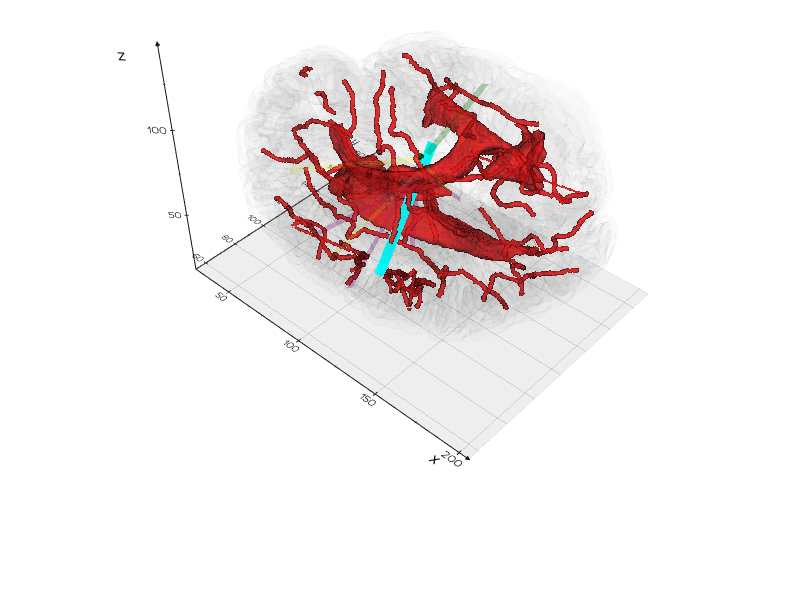

In [41]:
# Prepare actors for visualization with Nelder-Mead result
actors_nm = []
actors_nm.extend(brain_mask_structures)
if merged_obstacles:
    actors_nm.append(merged_obstacles)
if merged_stn:
    actors_nm.append(merged_stn)

# Add Monte Carlo results (faded)
actors_nm.extend(failed_lines)
actors_nm.extend(suboptimal_lines)
if best_path:
    # Make Monte Carlo best path more transparent
    mc_best_faded = best_path.clone().alpha(0.3)
    actors_nm.append(mc_best_faded)

# Add Nelder-Mead optimal path (bright cyan, on top)
actors_nm.append(nm_optimal_line)

print(f"Rendering scene with Nelder-Mead optimized path (cyan)...")
show(actors_nm, axes=1, viewup="z", 
     title=f"Weighted Sum + Nelder-Mead Optimization (w_obs={w_obstacle_norm:.2f}, w_len={w_path_length_norm:.2f})")

#### K3D

In [45]:
import k3d

# Create k3d plot for Nelder-Mead result
plot_nm = k3d.plot(name=f'Nelder-Mead Optimization (w_obs={w_obstacle_norm:.2f}, w_len={w_path_length_norm:.2f})')

# Add brain structures
print(f"Converting {len(brain_mask_structures)} brain mask structures...")
for mesh in brain_mask_structures:
    plot_nm += vedo_to_k3d_mesh(mesh, color=0x808080, opacity=0.01)

if merged_obstacles:
    print("Adding merged obstacles...")
    plot_nm += vedo_to_k3d_mesh(merged_obstacles, color=0xFF0000, opacity=0.75)

if merged_stn:
    print("Adding merged STN...")
    plot_nm += vedo_to_k3d_mesh(merged_stn, color=0x00FF00, opacity=1.0)

# Add Monte Carlo failed attempts (faded purple)
print(f"Adding {len(failed_lines)} failed attempts...")
for line in failed_lines:
    plot_nm += vedo_line_to_k3d(line, color=0x800080, width=FAILED_PATH_WIDTH * 0.5)

# Add Monte Carlo suboptimal paths (faded yellow)
print(f"Adding {len(suboptimal_lines)} suboptimal paths...")
for line in suboptimal_lines:
    plot_nm += vedo_line_to_k3d(line, color=0xFFFF00, width=SUBOPTIMAL_PATH_WIDTH * 0.5)

# Add Monte Carlo best path (faded green)
if best_path:
    print("Adding Monte Carlo best path (faded)...")
    plot_nm += vedo_line_to_k3d(best_path, color=0x00FF00, width=BEST_PATH_WIDTH * 0.7)

# Add Nelder-Mead optimal path (bright cyan, thicker)
print("Adding Nelder-Mead optimized path (cyan)...")
plot_nm += vedo_line_to_k3d(nm_optimal_line, color=0x00FFFF, width=BEST_PATH_WIDTH * 1.2)

print(f"Rendering Nelder-Mead optimization result...")
plot_nm.display()

Converting 91 brain mask structures...
Adding merged obstacles...
Adding merged STN...
Adding 5 failed attempts...
Adding 4 suboptimal paths...
Adding Monte Carlo best path (faded)...
Adding Nelder-Mead optimized path (cyan)...
Rendering Nelder-Mead optimization result...


Output()

## Visualization

Display the brain structures with all generated paths.

### Vedo

Rendering scene with 6 failed attempts, 3 suboptimal paths, and 1 optimal path...


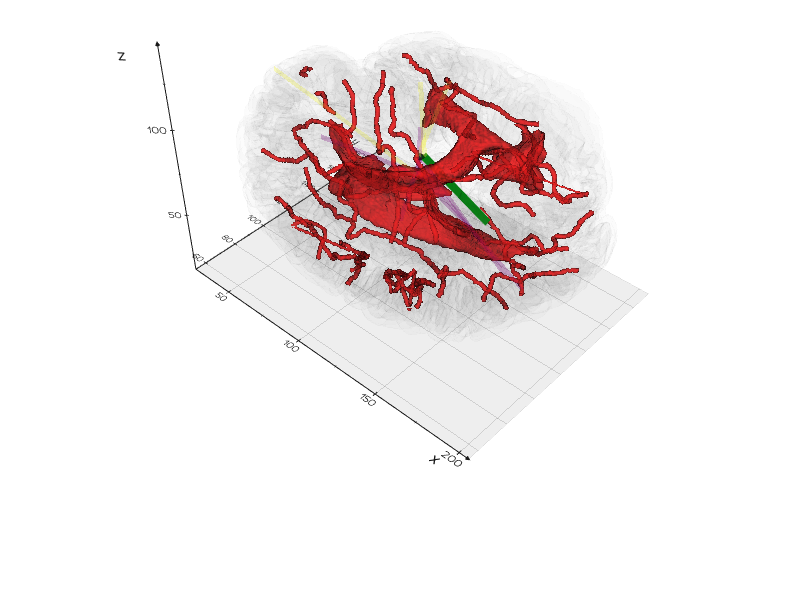

In [28]:
# Prepare actors for visualization
actors = []
actors.extend(brain_mask_structures)
if merged_obstacles:
    actors.append(merged_obstacles)
if merged_stn:
    actors.append(merged_stn)
# Add all failed attempts (intersecting paths)
actors.extend(failed_lines)
# Add suboptimal successful paths
actors.extend(suboptimal_lines)
# Add best path on top
if best_path:
    actors.append(best_path)

print(f"Rendering scene with {len(failed_lines)} failed attempts, {len(suboptimal_lines)} suboptimal paths, and 1 optimal path...")
show(actors, axes=1, viewup="z", title="Optimal Path To STN with Obstacle Distance")

### K3D

In [44]:
# Helper function to convert vedo mesh to k3d mesh
def vedo_to_k3d_mesh(vedo_mesh, color=None, opacity=1.0):
    """Convert a vedo mesh to k3d mesh format."""
    vertices = np.array(vedo_mesh.vertices, dtype=np.float32)
    faces = np.array(vedo_mesh.cells, dtype=np.uint32)
    
    # Get color from vedo mesh if not provided
    if color is None:
        vedo_color = vedo_mesh.color()
        if isinstance(vedo_color, str):
            # Convert color name to hex
            import matplotlib.colors as mcolors
            if vedo_color in mcolors.CSS4_COLORS:
                color_hex = mcolors.CSS4_COLORS[vedo_color]
                color = int(color_hex.lstrip('#'), 16)
            else:
                color = 0x808080  # default grey
        elif isinstance(vedo_color, (list, tuple)):
            # RGB to hex
            r, g, b = [int(c * 255) for c in vedo_color[:3]]
            color = (r << 16) | (g << 8) | b
        else:
            color = 0x808080
    
    # Get opacity from vedo mesh
    vedo_alpha = vedo_mesh.alpha()
    if vedo_alpha is not None:
        opacity = vedo_alpha
    
    return k3d.mesh(vertices, faces, color=color, opacity=opacity)

def vedo_line_to_k3d(vedo_line, color=None, width=0.1):
    """Convert a vedo Line to k3d line format."""
    line_scale_factor = 0.2
    points = np.array(vedo_line.vertices, dtype=np.float32)
    
    # Get color from vedo line if not provided
    if color is None:
        vedo_color = vedo_line.color()
        if isinstance(vedo_color, str):
            import matplotlib.colors as mcolors
            if vedo_color in mcolors.CSS4_COLORS:
                color_hex = mcolors.CSS4_COLORS[vedo_color]
                color = int(color_hex.lstrip('#'), 16)
            else:
                color = 0x00FF00  # default green
        elif isinstance(vedo_color, (list, tuple)):
            r, g, b = [int(c * 255) for c in vedo_color[:3]]
            color = (r << 16) | (g << 8) | b
        else:
            color = 0x00FF00
    
    return k3d.line(points, color=color, width=width*line_scale_factor)

In [34]:
import k3d

# Create k3d plot
plot = k3d.plot(name='Optimal Path To STN with Obstacle Distance')

# Prepare actors for visualization
print(f"Converting {len(brain_mask_structures)} brain mask structures...")
for mesh in brain_mask_structures:
    plot += vedo_to_k3d_mesh(mesh, color=0x808080, opacity=0.01)

if merged_obstacles:
    print("Adding merged obstacles...")
    plot += vedo_to_k3d_mesh(merged_obstacles, color=0xFF0000, opacity=0.75)

if merged_stn:
    print("Adding merged STN...")
    plot += vedo_to_k3d_mesh(merged_stn, color=0x00FF00, opacity=1.0)

# Add all failed attempts (intersecting paths)
print(f"Adding {len(failed_lines)} failed attempts...")
for line in failed_lines:
    plot += vedo_line_to_k3d(line, color=0x800080, width=FAILED_PATH_WIDTH)  # purple

# Add suboptimal successful paths
print(f"Adding {len(suboptimal_lines)} suboptimal paths...")
for line in suboptimal_lines:
    plot += vedo_line_to_k3d(line, color=0xFFFF00, width=SUBOPTIMAL_PATH_WIDTH)  # yellow

# Add best path on top
if best_path:
    print("Adding best path...")
    plot += vedo_line_to_k3d(best_path, color=0x00FF00, width=BEST_PATH_WIDTH)  # green, thicker

print(f"Rendering scene with {len(failed_lines)} failed attempts, {len(suboptimal_lines)} suboptimal paths, and 1 optimal path...")
plot.display()

Converting 91 brain mask structures...
Adding merged obstacles...
Adding merged STN...
Adding 6 failed attempts...
Adding 3 suboptimal paths...
Adding best path...
Rendering scene with 6 failed attempts, 3 suboptimal paths, and 1 optimal path...


Output()